In [370]:
#This is a class for reading edf files in python
import os
import struct
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

In [371]:
  properties (SetAccess = private)
    ver = 0;
    patientID = '';
    recordID = '';
    startDate = '';
    startTime = '';
    bytes = 0;
    records = 0;
    duration = 0;
    ns = 0;
    label = {};
    transducer = '';
    units = {};
    prefilter = '';
    samples = [];
    sf = [];
    conversion = [];
    dcOffset = []
  end
  
  properties (SetAccess = private, Hidden)
    physicalMin = [];
    physicalMax = [];
    digitalMin = [];
    digitalMax = [];
    dataOffset
    dataPointer
    baseScale = [];
    simpleStruct = true;
    dpLabelStr = {};
    reserved = [];
    reserved2 = [];
  end

IndentationError: unexpected indent (<ipython-input-371-e7661707e970>, line 2)

In [549]:
#Need to add other channel attributes such as analog,digital max and min, 
class channel(object):
    def __init__(self,edfFile,label=None,transducer=None,dimensions=None,
                physMin=None,physMax=None,digMin=None,digMax=None,
                 preFilter=None,sampleRate=None,notes=None,channelIndex=None):
        self.edfFile = edfFile
        self.label = label
        self.sampleRate = sampleRate
        #self.indexStart = indexStart
        self.transducer = transducer
        self.dimensions = dimensions
        self.physMin = physMin
        self.physMax = physMax
        self.digMin = digMin
        self.digMax = digMax
        self.preFilter = preFilter
        self.notes  = notes
        self.channelIndex = channelIndex
    
    def __str__(self):
        if self.label==None:
            return "None"
        else:
            return self.label + " - "+str(self.channelIndex)
        
    def channelIndex(self):
        return self.channelIndex
    
    def notes(self):
        return self.notes
    
    

class edfData(object):
    def __init__(self,fileId):
        self.fileId=fileId
        
    def __str__(self):
        return ("version: " + str(self.version) + "\nheader Bytes: " 
                + str(self.headerBytes) + "\nNum Records :" 
                + str(self.nRecords) + "\nNum Signals :" + str(self.nSignals) + "\nFile Size: "+str(self.fileSize))
                
                
    def loadFile(self,filepath):
        self.filePath = filepath
        self.fileSize = os.path.getsize(filepath)
        self.edfRawData = open(filepath,'rb')
        
    def printId(self):
        print"File Id: "+str(self.fileId)
   
    def fileParams(self):
        print("File Size: "+str(self.fileSize))
        
    def readBitsTest(self):
        self.edfRawData.seek(0)
        bits = self.edfRawData.read(100000)
        #self.edfRawData.seek(0)
        #print(self.edfRawData.read(10))
        #print("Some Bits: "+str(bits))
        return bits
        
    def parseEdf(self):
        '''
            This function parses the edf file getting the values of 
            the header fields. It also creates a channel object with 
            information about each channel.
        '''
        #Header Fields
        self.version = self.edfRawData.read(8)
        self.patientId = self.edfRawData.read(80)
        self.recordId = self.edfRawData.read(80)
        self.startDate = self.edfRawData.read(8)
        self.startTime = self.edfRawData.read(8)
        self.headerBytes = int(self.edfRawData.read(8))
        self.reservedBytes = self.edfRawData.read(44)
        self.nRecords = int(self.edfRawData.read(8))
        self.duration = self.edfRawData.read(8)
        self.nSignals = int(self.edfRawData.read(4))
        
        #Channel Fields
        '''
        self.labels = self.edfRawData.read(self.nSignals*16).split()
        self.transducer = self.edfRawData.read(self.nSignals*80).split()
        self.dimensions = self.edfRawData.read(self.nSignals*8).split()
        self.physMin = self.edfRawData.read(self.nSignals*8).split()
        self.physMax = self.edfRawData.read(self.nSignals*8).split()
        self.digMin = self.edfRawData.read(self.nSignals*8).split()
        self.digMax = self.edfRawData.read(self.nSignals*8).split()
        self.preFilter = self.edfRawData.read(self.nSignals*80).split()
        self.sampleRate = self.edfRawData.read(self.nSignals*8).split()
        self.reservedNotes = self.edfRawData.read(self.nSignals*32).split()
        '''
        #This should be changed to be per channel, must add channel class to make more portable
        #self.channelLength = 2*int(self.nRecords)*int(self.sampleRate[0])
        self.channels = {}
        channelFields = ['labels','transducer','dimensions','physMin','physMax','digMin','digMax',
                        'preFilter','sampleRate','reservedNotes']
        self.channels['labels'] = self.edfRawData.read(self.nSignals*16).split()
        self.channels['transducer'] = self.edfRawData.read(self.nSignals*80).split()
        self.channels['dimensions'] = self.edfRawData.read(self.nSignals*8).split()
        self.channels['physMin'] = self.edfRawData.read(self.nSignals*8).split()
        self.channels['physMax'] = self.edfRawData.read(self.nSignals*8).split()
        self.channels['digMin'] = self.edfRawData.read(self.nSignals*8).split()
        self.channels['digMax'] = self.edfRawData.read(self.nSignals*8).split()
        self.channels['preFilter'] = self.edfRawData.read(self.nSignals*80).split()
        self.channels['sampleRate'] = self.edfRawData.read(self.nSignals*8).split()
        self.channels['reservedNotes'] = self.edfRawData.read(self.nSignals*32).split()
        
        self.channelObjects = []
        channelDataStart = self.headerBytes
        
        for i in xrange(int(self.nSignals)):
            channelValues ={'filepath':self.filePath}
            channelIndex = channelDataStart + int(self.channels['sampleRate'][i])*self.nRecords*i*2
            for j in channelFields:
                try:
                    channelValues[j]=(self.channels[j][i])
                except:
                    channelValues[j] = None
            self.channelObjects.append(
                channel(channelValues['filepath'],channelValues['labels'],channelValues['transducer'],
                        channelValues['dimensions'],channelValues['physMin'],channelValues['physMax'],
                        channelValues['digMin'],channelValues['digMax'],channelValues['preFilter'],
                        channelValues['sampleRate'],channelValues['reservedNotes'],
                        channelIndex))
            
        '''
        for i in xrange(len(self.labels)):
            newChannel = channel(self.filePath,self.labels[i],self.transducer[i],
                                self.dimensions[i],self.physMin[i],self.physMax[i],
                                self.digMin[i],self.digMax[i],self.preFilter[i],
                                self.sampleRate[i],self.reservedNotes[i])
            self.channels.append(newChannel)
        '''  
        #self.channelStarts = {}
        #for i in xrange(len(self.labels)):
        #    self.channelStarts[self.labels[i]] = int(self.channelLength)*i-int(self.headerBytes)

        def dataValues(self,timeStart,duration):
            '''
                Returns data values for all channels 
                for duration specified from the 
                desired location of the study
            '''
            return None
        
    
        #self.edfRawData.seek(240000)
        
        #print("100 Bytes of EEG \n"+str(self.edfRawData.read(100)))
    def parseTest(self):
        print "version: " + str(self.version)
        print "header Bytes: " + str(self.headerBytes)
        print "Num Records :" + str(self.nRecords)
        print "Num Signals :" + str(self.nSignals)
        '''
        print "Labels: "+str(self.labels[3])
        print "Num Labels: "+str(len(self.labels))
        print "Transducer: "+str(self.transducer)
        print "Dimensions: "+str(self.dimensions)
        print "physMin: "+str(self.physMin)
        print "physMax: "+str(self.physMax)
        print "digMin: "+str(self.digMin)
        print "digMax: "+str(self.digMax)
        print "Filter: "+str(self.preFilter)
        print "Samples in Record: "+str(self.sampleRate)
        print "Reserved Notes: "+str(self.reservedNotes)
        print ""
        print "Channel Byte Length: "+str(self.channelLength)
        print "Channel Indices: "+str(self.channelStarts)
        '''
        self.sampleDataList = []
        
        print "----------------------------------------------\nChannel Dict: "+str(self.channels['labels'])
        
        for x in self.channelObjects:
            print x
            
        for i in xrange(1000):
            self.sampleDataList.append(struct.unpack('h',self.edfRawData.read(2))[0])
            
        print self.sampleDataList
        
        #print "Raw Data 1"+str(float(dataSample))
        
        
        
        
        
        

In [550]:
fileSize = os.path.getsize('edfReader.ipynb')
print fileSize

44861


In [551]:
sampleFile = edfData(10)
sampleFile.printId()

File Id: 10


In [552]:
edfFile1 = edfData(1)
edfFile1.loadFile("chb01_01.edf")
#edfFile1.fileParams()

#b = x.read(1)
#firstfivebits = b >> 3

#

edfFile1.parseEdf()
edfFile1.parseTest()
print(edfFile1)

version: 0       
header Bytes: 6144
Num Records :3600
Num Signals :23
----------------------------------------------
Channel Dict: ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8']
FP1-F7 - 6144
F7-T7 - 927744
T7-P7 - 1849344
P7-O1 - 2770944
FP1-F3 - 3692544
F3-C3 - 4614144
C3-P3 - 5535744
P3-O1 - 6457344
FP2-F4 - 7378944
F4-C4 - 8300544
C4-P4 - 9222144
P4-O2 - 10143744
FP2-F8 - 11065344
F8-T8 - 11986944
T8-P8 - 12908544
P8-O2 - 13830144
FZ-CZ - 14751744
CZ-PZ - 15673344
P7-T7 - 16594944
T7-FT9 - 17516544
FT9-FT10 - 18438144
FT10-T8 - 19359744
T8-P8 - 20281344
[-374, 0, 0, 0, 0, 2, 1, -5, -4, 7, 10, 9, 5, -11, -5, 9, 23, 28, 12, 2, 11, 28, 32, 40, 55, 57, 48, 37, 28, 4, -16, -3, 0, -18, -22, -37, -64, -66, -51, -48, -65, -63, -90, -116, -117, -102, -93, -86, -80, -78, -81, -80, -84, -84, -62, -18, 20, 26, 23, 24, 18, 39

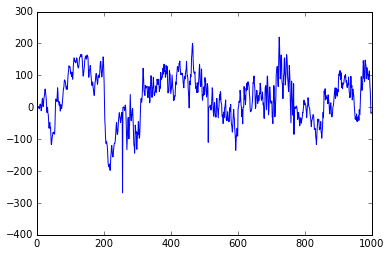

In [500]:
plt.figure()
plt.plot(edfFile1.sampleDataList)